## Preparing the data


Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [2]:
plt.rcParams['figure.figsize'] = (20,6)

Reading the data from excel format

In [3]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 35.4MB/s]


In [4]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [5]:
# set index as date
mobile_sales.set_index('DATE', inplace=True)

mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


## Data Preprocessing (Recap from last lecture)

Let's do all the data processing we learnt about in the last lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

<Axes: xlabel='DATE'>

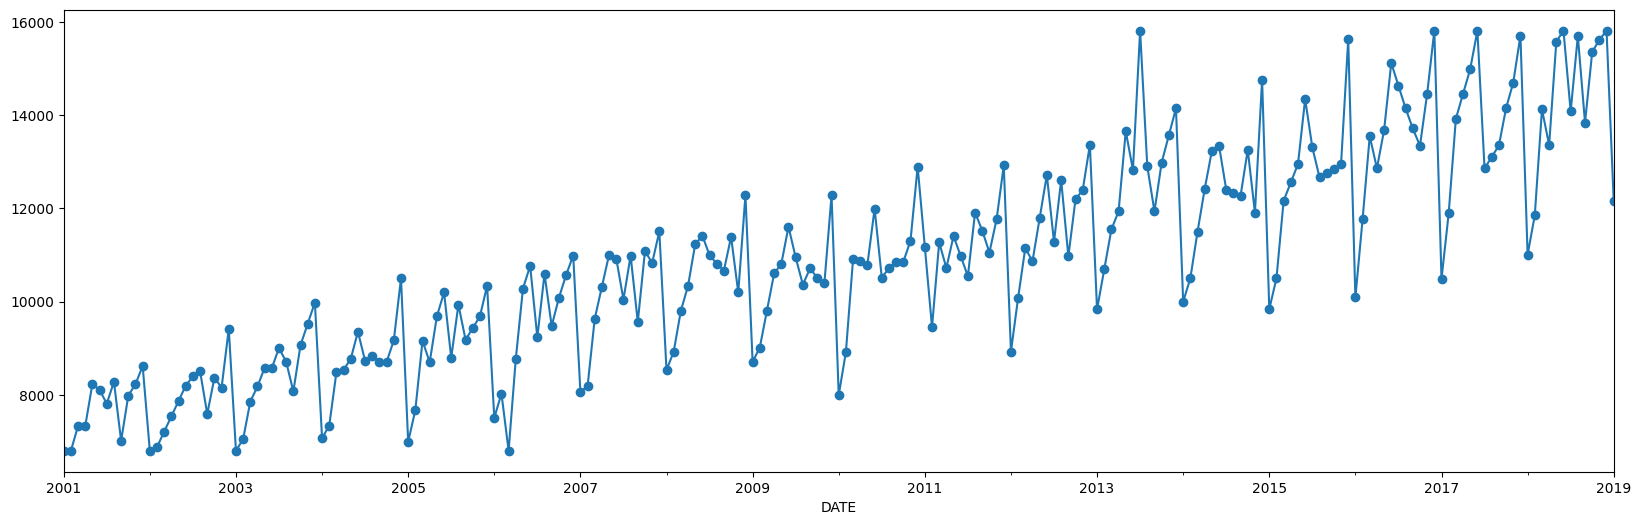

In [6]:

# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

**Train - test splitting of data**

In [7]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0


Also, let's create a function  to estimate the performance of different models

In [8]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

Recall that in the last lecture, we had not gotten the desired MAPE score using the **simple methods**.

Now that we've performed the required preprocessing on our time series, and even split it into train and test sets, lets look at another family of forecasting techniques, called **smoothing based models**.

---

# Smoothing Based Methods


Let's expand more on the Moving Averages model.
## 1. Moving average forecasting (Implementation)

We saw the illustration of concept of Moving averages using the `rolling()` function.

> **Q. How can we forecast future values using Moving Average concept?**

In order to make our forecast, we want to take the average of last 3 data values.

Let's look at the scratch implementation of the same.

![picture](https://drive.google.com/uc?export=view&id=1pFngGfjJUL-1wV2Gw2gQyfwT87Qa53tN)

Let's make a copy of the series in df, to avoid making changes in the original series.



In [9]:
import numpy as np

df = mobile_sales.copy()

> **Q. How do we obtain the dates for our future forecasts?**

Since we're working with a time series, naturally, we need to first create new data points with the future dates

As of now we have data till 2019-01-01, but we wish to forecast values for future.

The function **pd.date_range** is used to create the new dates for giving the forecasted values

We need to specify the following parameters in **pd.date_range**:-
- `start`: left bound for generating dates
- `periods`: Number of time steps in the range
- `freq`: frequency aliases, since we need month start frequency, our alias is `MS`. There are many more aliases.

Using the **pd.date_range**, we create a new dataframe that we can append to the existing one.

In [10]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS'))

""
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01



**Note:**
- Notice that we got the first entry as Jan-2019, which already existed in our series.
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence we utilise slicing by mentioning `[1:]`

In [11]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')[1:]))

df.tail(20)

,Sales
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0
2018-12-01,15809.4
2019-01-01,12160.0
2019-02-01,NaN
2019-03-01,NaN


> **Q. How can we forecast future values using concept of Moving Averages?**

In order to forecast value for time t=k, we take average value of  the past n points, $x_{t-1}, x_{t-2}, x_{t-3}, ..., x_{t-n}$.

Calculate next point from MA of previous points. Then calculate the 2nd point using 1 previous forcasted point and remaining actual points and so on.

![picture](https://drive.google.com/uc?export=view&id=19cmb7-9VP-Vm7SxE9qEO1KUp6mn1PyZR)

<br>

> **Q. How do we code this?**

First, lets initialise a new variable `pred` to all the sales that are not NaN.

Now we run a loop. Since we wish to predict values for a year, the loop iterates 12 times.

Take the average of last 3 values on every iteration, and append it to the series.




In [12]:
df.Sales.tail(15)

2018-11-01    15615.0
2018-12-01    15809.4
2019-01-01    12160.0
2019-02-01        NaN
2019-03-01        NaN
2019-04-01        NaN
2019-05-01        NaN
2019-06-01        NaN
2019-07-01        NaN
2019-08-01        NaN
2019-09-01        NaN
2019-10-01        NaN
2019-11-01        NaN
2019-12-01        NaN
2020-01-01        NaN
Name: Sales, dtype: float64

In [13]:
pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

pred[-20:]

array([15809.4       , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 15809.4       , 12160.        ,
       14528.13333333, 14165.84444444, 13617.99259259, 14103.99012346,
       13962.6090535 , 13894.86392318, 13987.15436671, 13948.20911446,
       13943.40913479, 13959.59087199, 13950.40304041, 13951.13434906])

So, we can see that we have forecasts here, based on average of last 3 points for all new points.

Let's round them.

In [14]:
pred = pred.round(1)
pred[-20:]

array([15809.4, 14080. , 15697. , 13838. , 15351. , 15615. , 15809.4,
       12160. , 14528.1, 14165.8, 13618. , 14104. , 13962.6, 13894.9,
       13987.2, 13948.2, 13943.4, 13959.6, 13950.4, 13951.1])

Now let's plot this.

<Axes: >

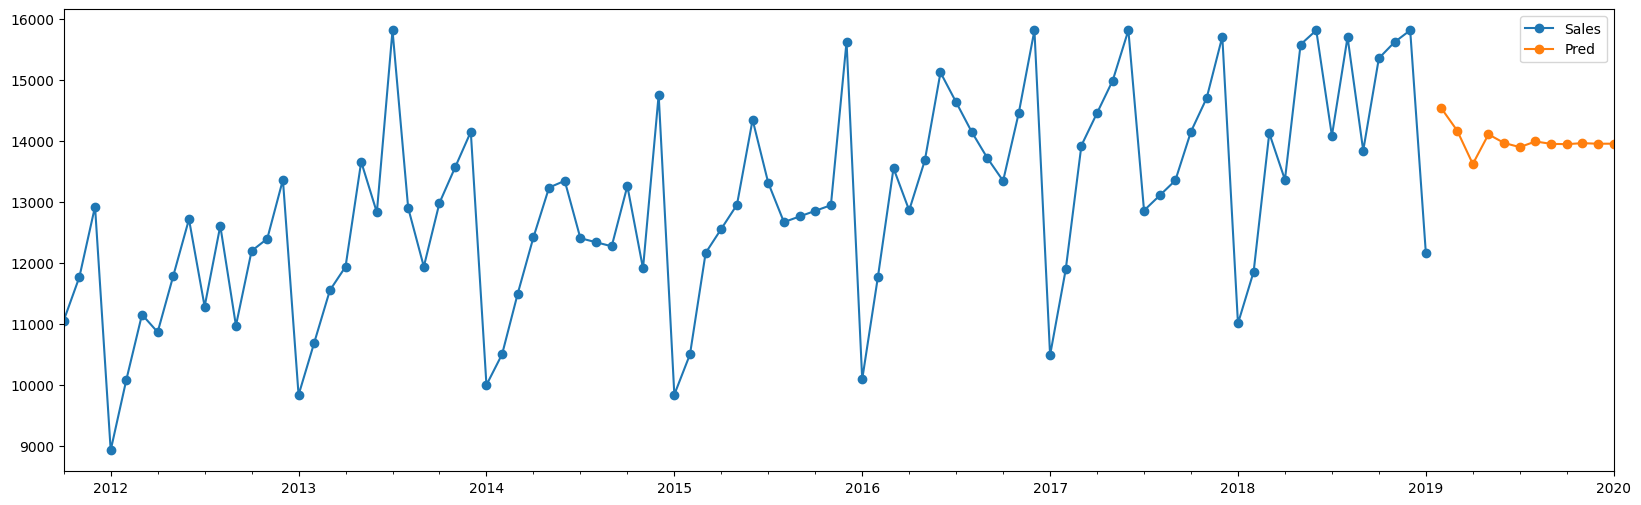

In [15]:
df['Pred'] = pred

df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(100).plot(style='-o')

> **Q. Does this look like a good forecast?**

These forecasted values are certainly better than forecasting the mean/median or any constant values. At least, the levels looks okay.

However, it can be clearly seen that the forecast is not able to predict the variations and it gives a flat line after few predictions.

<br>

Also, if you think about it, this technique, doesn't seem to using the past data.

What is the point of having data spanning over 18 years, if we're just looking at the last 3 entries to forecast a new value.

> **Q. What would be the performance of the Moving Averages model?**

While we're at it, let's check the performance of Moving Averages model also, by using train and test sets.

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


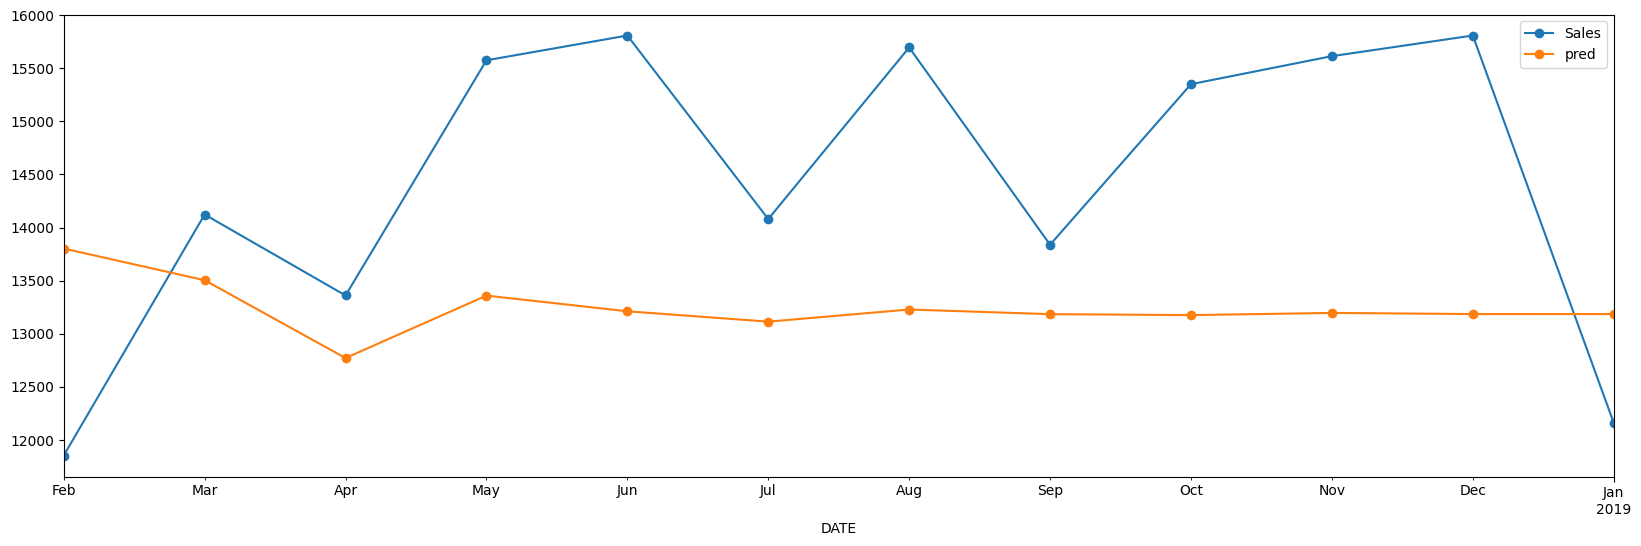

In [16]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As per MAPE, we can say that our model has 11.5% error.

This is much better than the other models we saw. Lets look at more models.

## 2. Simple exponential smoothing

In order to avoid the shortcomings of Moving average forecasts, lets look at another forecasting technique, called **Simple exponential technique**.

> **Q. What is the idea behind Simple exponential technique?**

The key idea is that, we want to keep some memory of the entire time series, but also, we want to give more value to the recent most data.

Instead of ignoring the past values completely, let's assign them a small weight.

The major weight would still be assigned to the recent most entry.

This forms a decaying trend.

<br>

> **Q. Why do we need to consider the older data?**

 Let us assume a company was doing good for 10 years, and the sales went down for last 2 years because of **COVID-19** :
* Now if we predict sales, basing on the past few months, the forecast would be very low which is not an optimal prediction
* Hence it is required to consider the past series also to get a better forecast.


![picture](https://drive.google.com/uc?export=view&id=177iuo0YBDxvVoAYOh1pH4dSuTRjcN1V2)

<br>

#### Q. How can this idea be formulated mathematically?
Let's consider the weight we assign to the recent most value be $\alpha$.

$\alpha$ is called the **smoothing parameter**.

So, our forecast at time t becomes,

$ŷ_{t+h} = α*y_{t} + (1-α)*ŷ_{t}$

Here, $h$ is the **horizon**, it can take values such as $h=1, 2, 3, 4, ..$, it depicts the number of steps in future.

<br>

> **Q. We wanted to consider the entire time series, this formulation just has data of 2 points, why?**

This formulation is actually **recursive** in nature.

So, when we write $ŷ_{t-1}$, that gets broken down further as

$ŷ_{t+h} = α * y_{t} + (1-α)* [α* y_{t-1} + (1-α)*ŷ _{t-2}]$

This is further recursed in order to incorporate the entire time series.

<br>

> **Note:-**
- So, the concise form of writing the equation for SES is: $ŷ_{t+1} = αy_{t} + (1-α)ŷ_{t}$
- But if we were to open the expansion, the SES formulation is actually: $ŷ_{t+1} = αy_{t} + α(1-α)y_{t-1} + α(1-α)^2ŷ _{t-2} + ...$
- These are just different ways of writing the same equation; they're equivalent.



![picture](https://drive.google.com/uc?export=view&id=1UruTOKBSFF33-pVQH4_VYPiHHrC4oy8E)

<br>

> **Q. What does the plot of weights look like?**

We give more weightage to the most recent values, and this weightage keeps decreasing for earlier values.

As you can see from the formulation also, weights are exponentially decaying.

This is why. we call this method **Simple Exponential Smoothing**.


![picture](https://drive.google.com/uc?export=view&id=1ewCKPMW-_8CjtP2j5tgcdn_24C5aKaMH)

> **Q. How can we implement this concept in code?**

Let's look into the code for the same.

We have a built-in method for this technique `SimpleExpSmoothing()`, under **statsmodels** library.

While fitting this model, we need to specify the `smoothing_level` parameter, which is the same as $\alpha$ we've been looking at.
- The recommended starting point value for `smoothing_level` is $\frac{1}{2* seasonality}$
- For our case, this becomes $\frac{1}{2*12}$


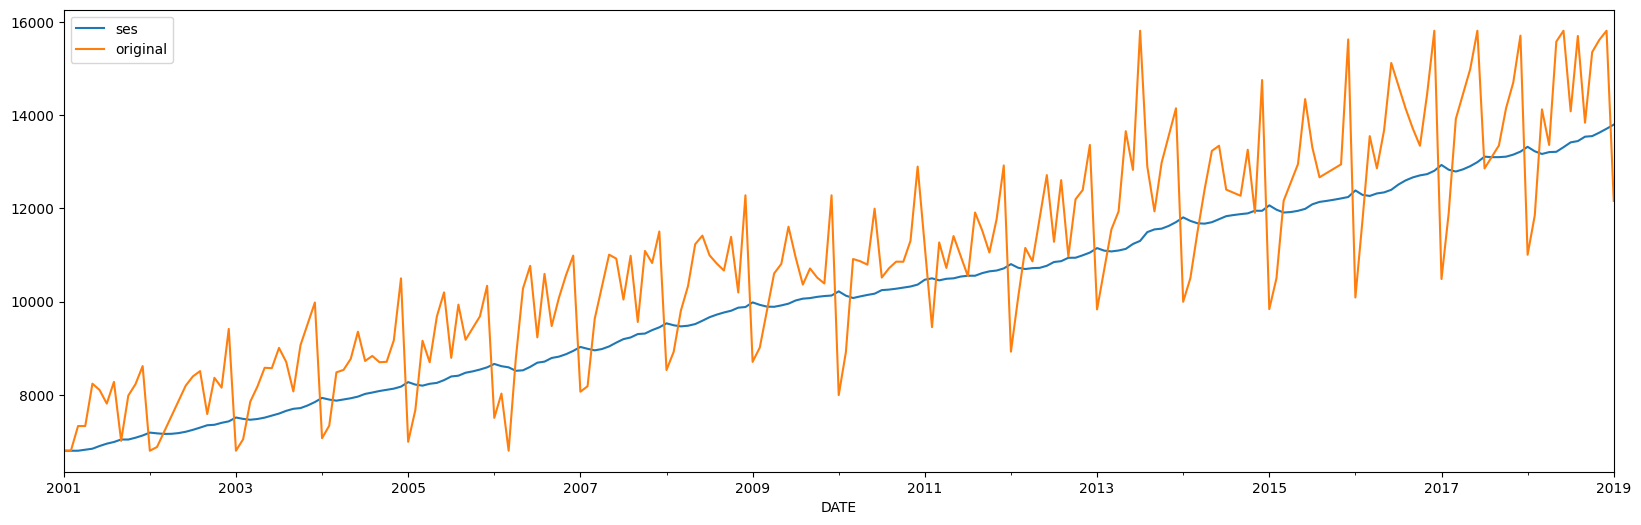

In [17]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

model.plot(label='ses')
mobile_sales.Sales.plot(label='original')
plt.legend()

From the graph, it looks like the Simple Exponential Smoothing, got the levels right.

> **Q. How is this plot different from Moving Averages plot?**

This looks similar.

But, Unlike moving averages, it **does not have the offset** in beginning and end, because this method is initialised properly.

They fix the previous values as well.

<br>

> **Q. How can we make future forecasts from this method?**

`SimpleExpSmoothing` in statsmodels also have a `forecast()` method.

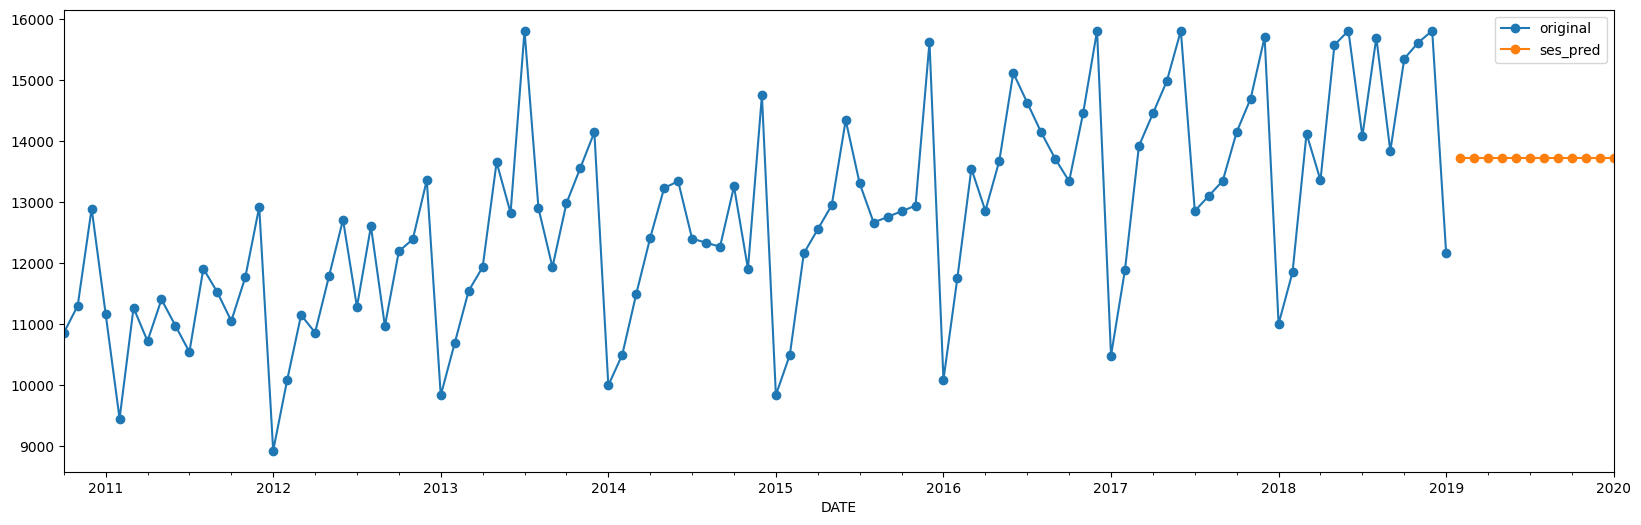

In [18]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))
pred = model.forecast(steps = 12)

mobile_sales.Sales.tail(100).plot(label='original', style='-o')

pred.plot(label='ses_pred', style='-o')
plt.legend()

> **Q. Is this a good forecast?**

**No.**

In fact, it looks even worse. This is a complete straight line, surely, it can't be a good forecast.

This is because you dont have the previous *actual value* available for horizon > 1. So the current forecast is used for all next values.

But one advantage is that the **level of the forecasted values are right**.

So, we have the right levels, if we can predict the trend and seasonality right, we should get a good forecast.

<br>

Since it captures the correct level, for the forecast, this model would've worked well if:
- Consider our business case: We have data till January
- Suppose we are asked to forecast sales value for next month (February): $\hat{y}_{t+1}$
- Then we wait for Februaryto end, to observe the actual sales value: $y_{t+1}$
- Now, we forecast the value for March: $\hat{y}_{t+2}$
- This way, SES would be able to captue the trend also.

But this is not our business case, we've been asked to forecast values for the next 12 months.

![picture](https://drive.google.com/uc?export=view&id=16imbVgcjvQuwWlmkMjDL-SoHU4RimebP)


<br>


> **Q. What would be the performance of the Simple Exponential model?**

While we're at it, let's check the performance of Simple Exponential model also, by using train and test sets.

MAE : 1621.49
RMSE : 1830.741
MAPE: 0.109


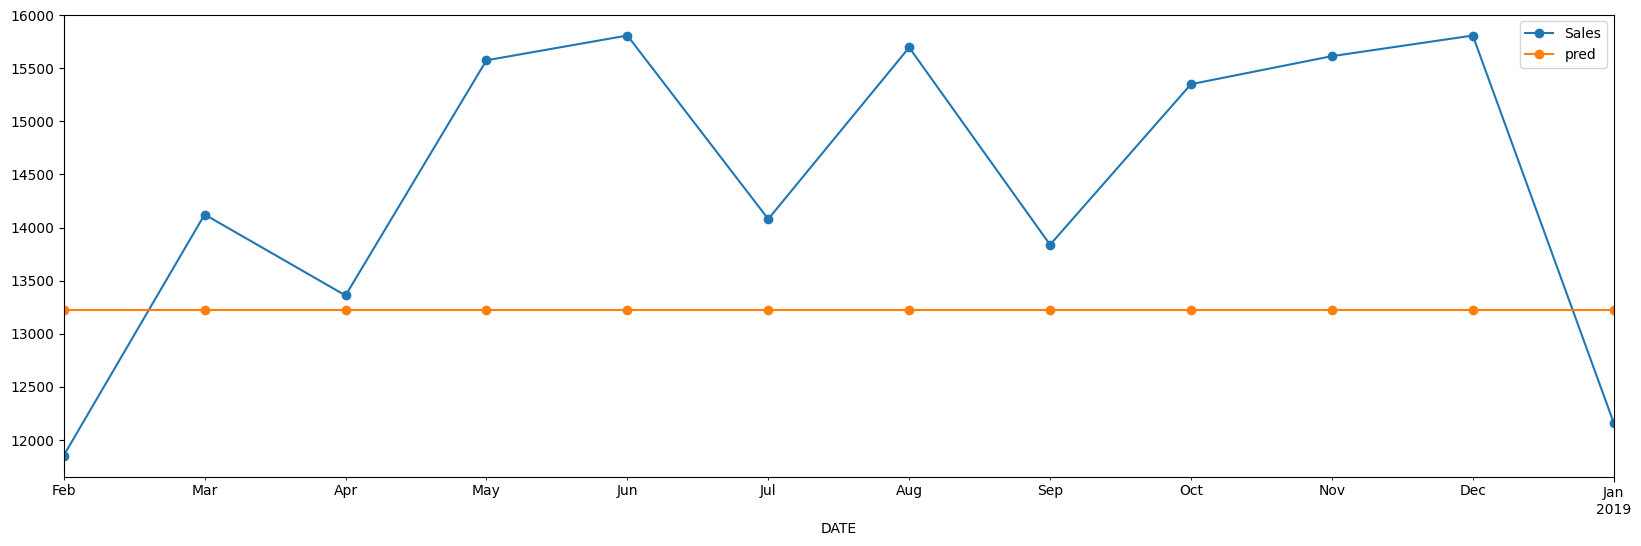

In [19]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As expected, the prediction is a straight line, but the erros is 10% which is less than the error of  moving average.

So this model is performing better.

<br>

The SES Model is missing both
- trend, and
- seasonality




---

##3. Double Exponential smoothing (Holt's method)

We saw the shortcomings of Simple Exponential model
- doesn't capture the trend
- gives one unique value

> **Q. How can we overcome these shortcomings?**

Perhaps if we introduce the trend value to the formulation, we can fix the problem of getting a straight line.

Since we want the trend of entire time series, in order to incorporate them, we will have to provide weights to the trend value also.

Naturally, this will also form a exponentially decaying series.

Hence this is called **Double Exponential smoothing (aka Holt's method)**

<br>

#### Q. How does our formulation change by incorporating trend?

We have to assign weights to the trend values also.

Hence, the formulation becomes

 $ŷ_{t+h} = l_{t} + hb_{t}$

where,
$l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1})$

We call this as the **level** of time series at time t.

**Remember:** This is still a recursive function.


<br>

> **Q. How can we calculate trend value?**

We know from Calculas, that we can calculate **slope** of a curve by the formula
$\frac{Δy}{Δt} = \frac{y_t - y_{t-1}}{Δt}$

For our case, this becomes,
$\frac{Δy}{Δt} = y_t - y_{t-1}$ as $Δt = 1$

This slope value would actually also be equal to the **trend** of the series.

By plugging this in, the trend function can be calculated as,

$b_t = β*(l_t - l_{t-1}) + (1-\beta)*b_{t-1}$

where, $\beta$ is a parameter that needs to be tuned, if we're implementing the model from scratch.

![picture](https://drive.google.com/uc?export=view&id=1FS553cP4dE9bLb9pGL7m7u3tYzIj2i5R)

<br>

So, we can see that value of y depends on the trend value (b), and value of b, in turn depends on value of y.


> **Q. How can we implement double exponential smoothing in code?**

Within our `ExponentialSmoothing()` function of statsmodels, we can assign the parameter `trend`.

Based on whether we wish to use an Additive or a Multiplicative model, we can assign `trend="add"` or `trend="mul"` respectively.

This way, the trend gets incorporated into the smoothing function.

Let's see the plot after double exponential smoothing.

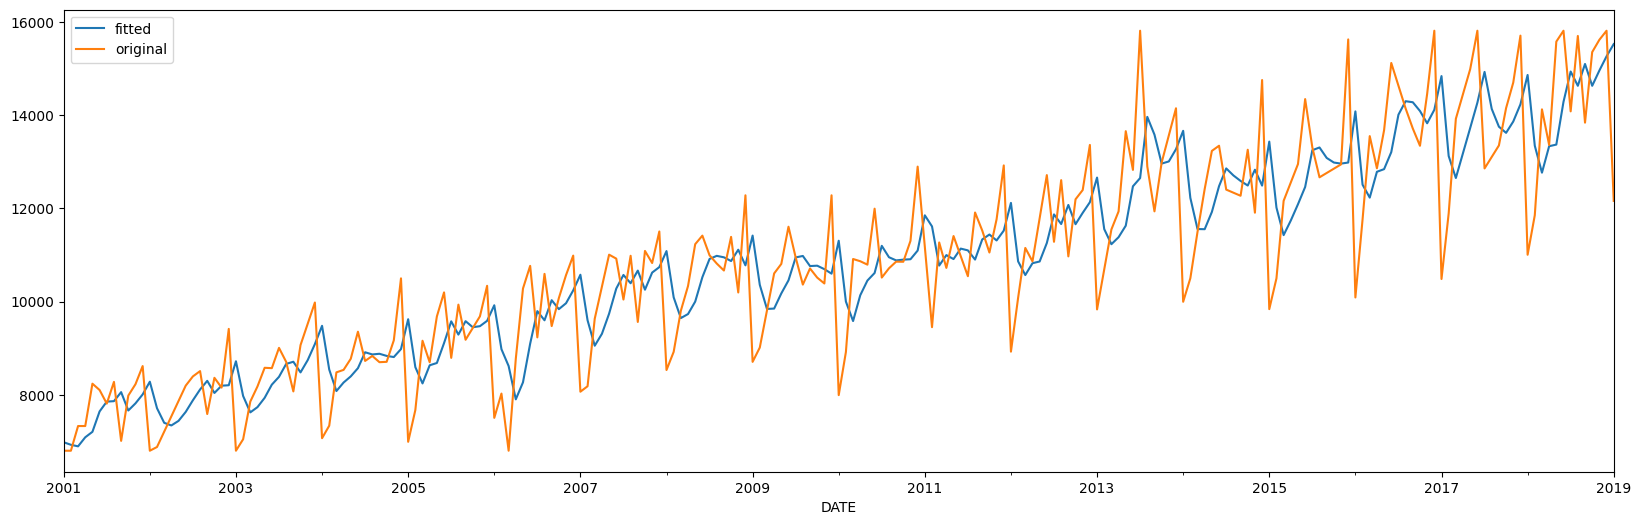

In [20]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit(smoothing_level=0.4)
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

This looks like a much better fit than the Simple exponential smoothing.

<br>

Now, lets look at the forecasts.
> **Q. Can you imagine what forecasts with this technique would look like?**

As per the simple exponential technique, we were just getting a straight line of forecasts.

Here, we've incorporated the trend value of the entire time series also.

We know that the trend for given series is increasing.

So perhaps, we will get a plot with forecasts along the trend line.


![picture](https://drive.google.com/uc?export=view&id=1qvZ_1Jn346phEcAzJnnZpuXgqAXzjLrv)

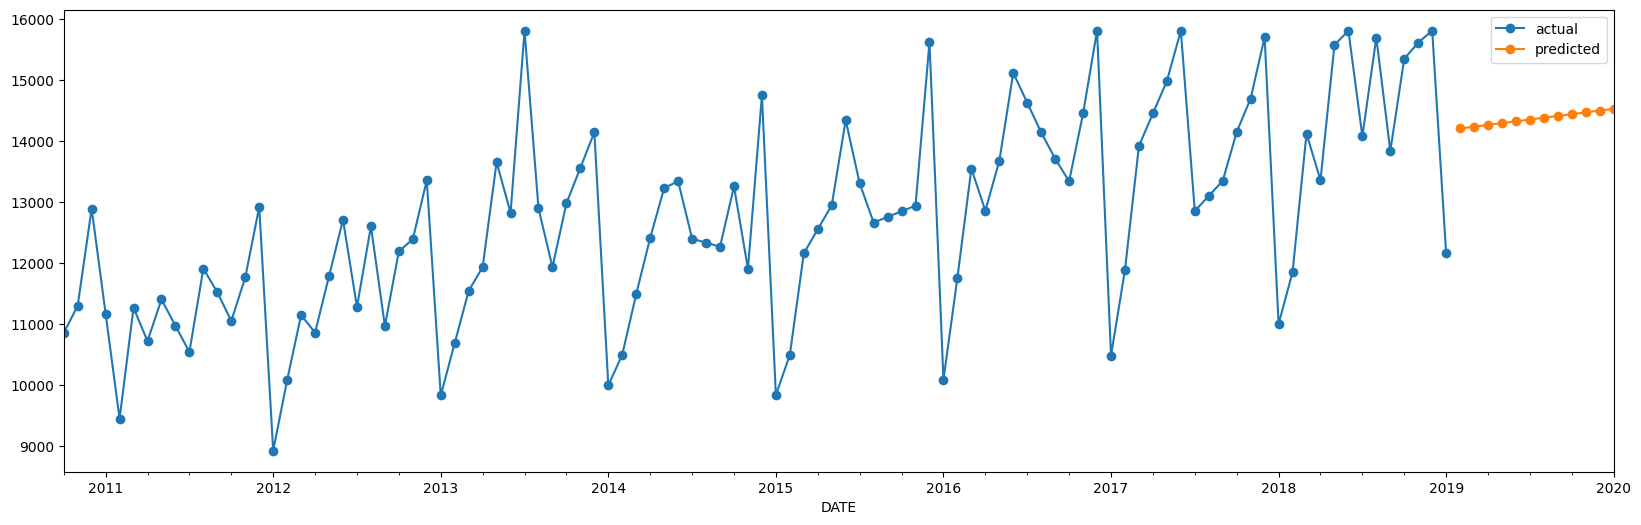

In [21]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

From the graph you can see that, the trend of the series is also obtained along with the level of values.

<br>


> **Q. What would be the performance of the Double Exponential model?**

While we're at it, let's check the performance of Holt's method model also, by using train and test sets.

MAE : 1163.781
RMSE : 1352.497
MAPE: 0.083


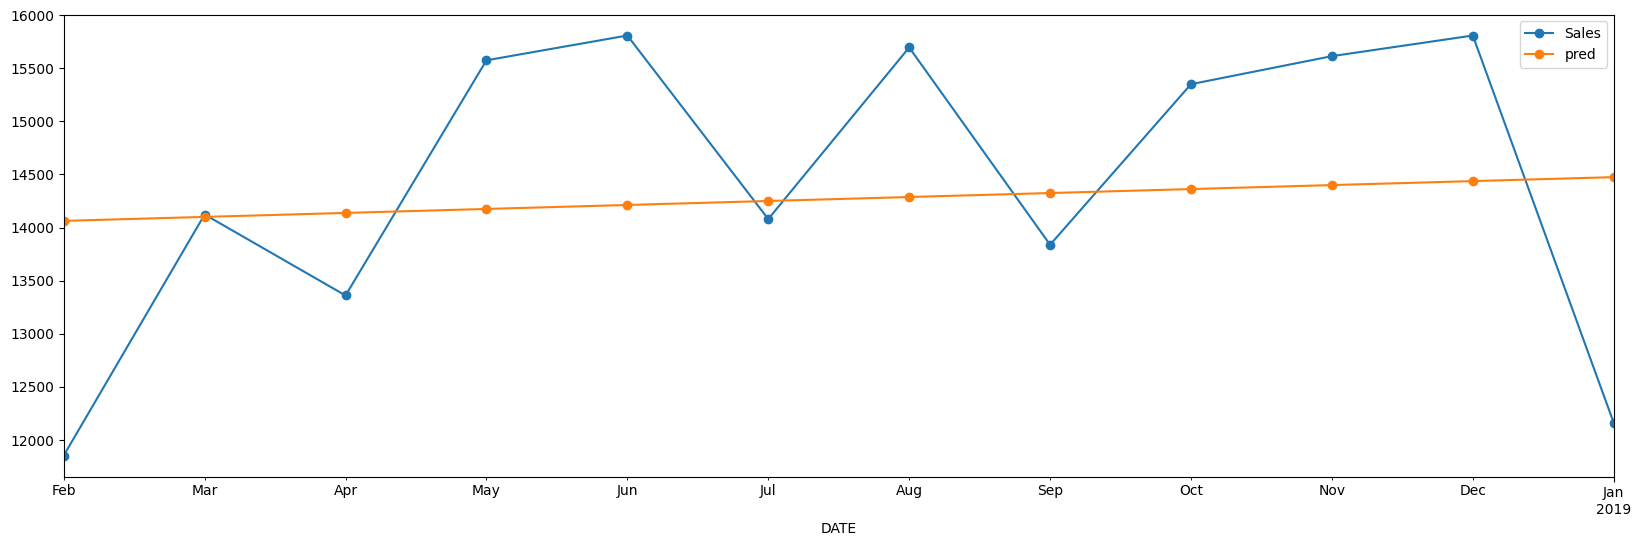

In [22]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Again, the error has reduced to 8.3% now.

Also, the MAE and RMSE values also dropped.

---

## 4. Triple Exponential smoothing (aka Holt-Winters Method)

> **Q. What can we do to further improve the quality of our forecasts?**

We can perhaps add the seasonality of the timeseries also, that way we'll get rid of the straight line forecasts.

<br>

>**Q. How does this change the math formulation?**

Upon incorporating the seasonality, our equation becomes,

$\hat{y}_{t+h} = l_t + hb_t + s_{t+h-m}$

where m -> frequency of the seasonality, i.e., the number of seasons in a year.

For example, for quarterly data m=4, and for monthly data  m=12.

Here,

$l_t = α (y_t - s_{t-m}) + (1-α)(l_{t-1} + b_{t-1})$

$b_t = β (l_t - l_{t-1}) + (1-β)b_{t-1}$

$s_t = γ (y_t - l_{t-1} - b_{t-1}) + (1-γ)s_{t-m}$


![picture](https://drive.google.com/uc?export=view&id=1bYC7H3ILQ3yaZ6hixpykuyuCUX6MlK2h)

> **NOTE:**
- There is another implementation of Holt Winters' model, that incorporates the multiplicative model
- This changes the math slightly, but math is not very important, the point here was to build the intuition for Holt Winters.

> **Q. How can we implement triple exponential smoothing in code?**

Within our `ExponentialSmoothing()` function of statsmodels, we can assign the parameters `trend=True` and `seasonal=True`.

This way, the trend and seasonality get incorporated into the smoothing function.

Let's see the plot after triple exponential smoothing.

<Axes: xlabel='DATE'>

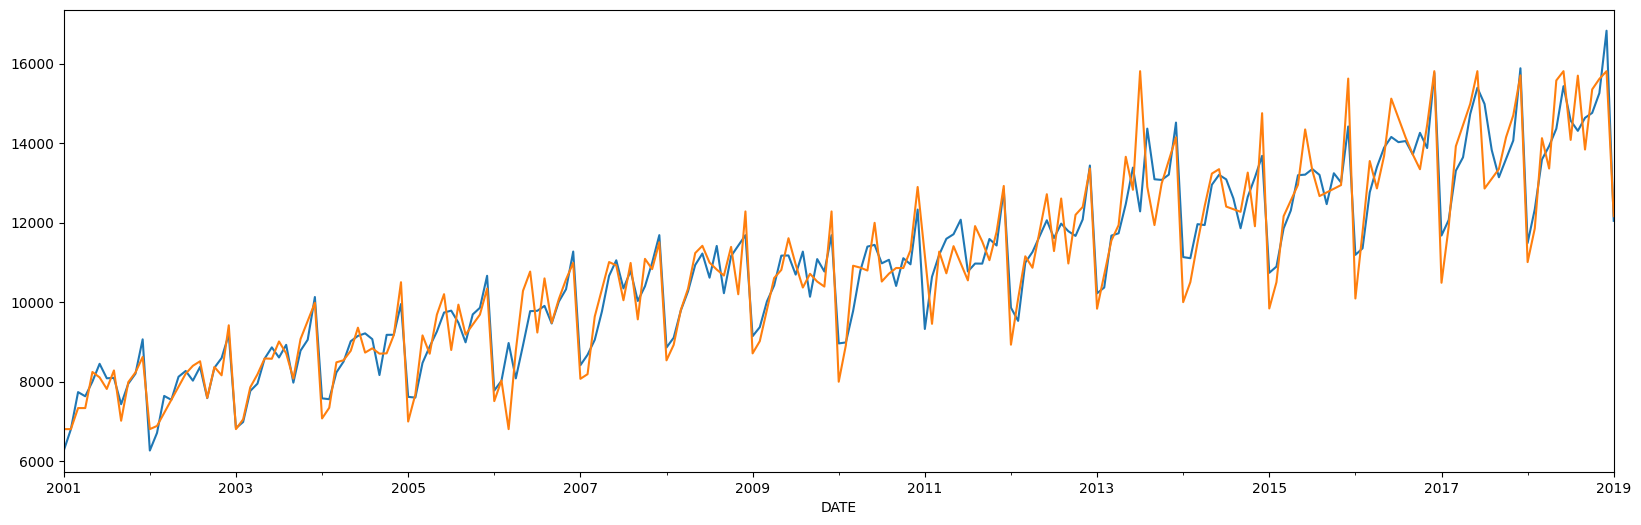

In [23]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=0.4)
model.fittedvalues.plot()
mobile_sales.Sales.plot()

As you can see, this captures more information than Double Exponential smoothing.

This was expected as it has more degrees of freedom to capture more data.

<br>

Now, lets look at the forecasts.
> **Q. Can you imagine what forecasts with this technique would look like?**

As per the double exponential technique, we were just getting a straight line of forecasts along the trend line.

Here, we've incorporated the seasonality value of the entire time series also.

So perhaps, we will get a good forecast now.

![picture](https://drive.google.com/uc?export=view&id=1FextDENk7sSpUtCuT_IkhyJrx4mc4iEG)

<Axes: xlabel='DATE'>

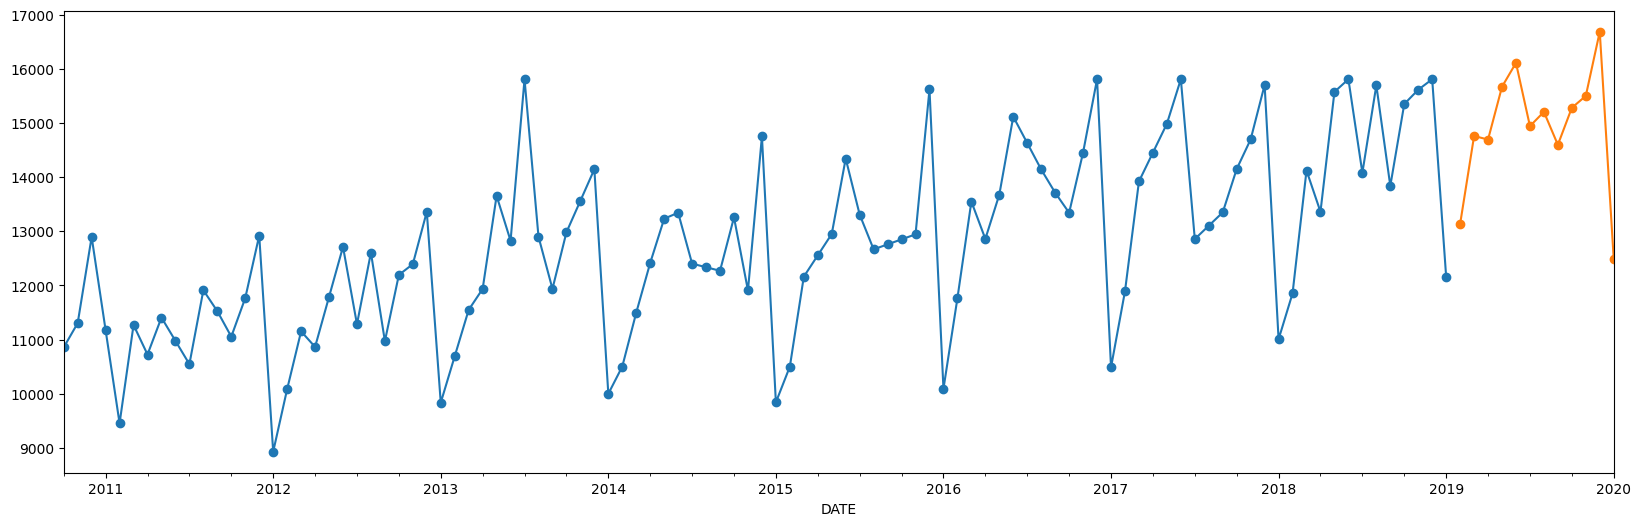

In [24]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o')
pred.plot(style='-o')

<Axes: xlabel='DATE'>

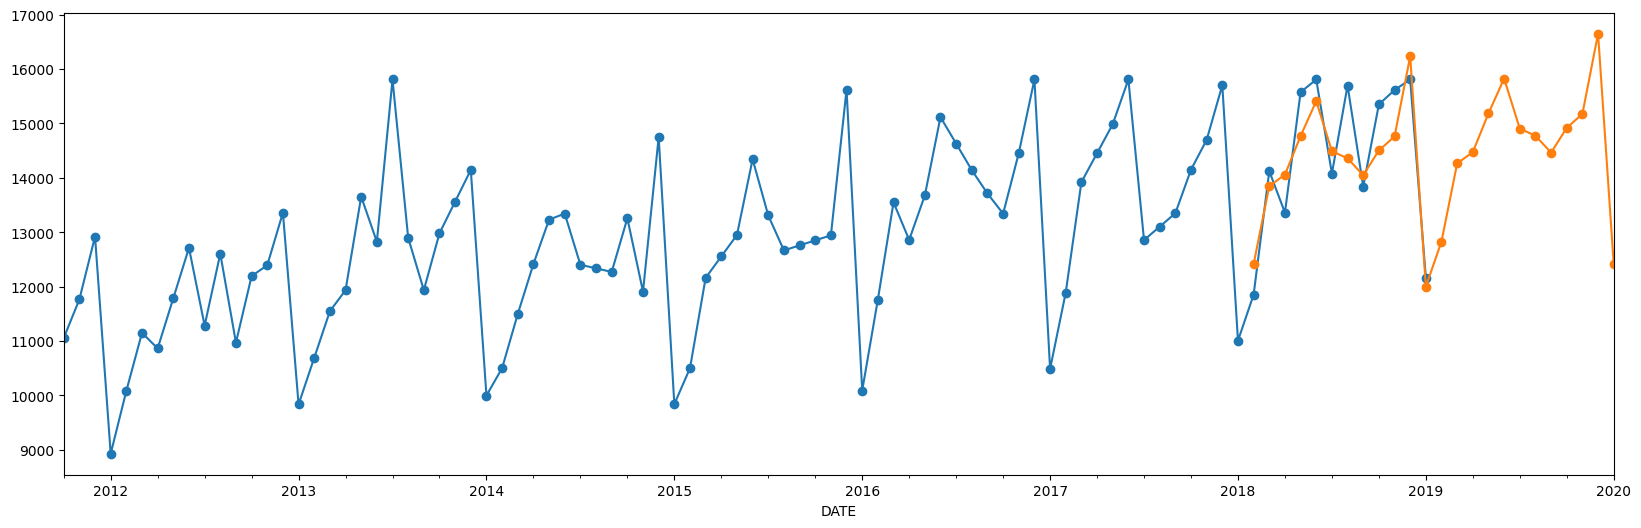

In [27]:
pred = model.forecast(steps = 24)
mobile_sales.Sales.tail(88).plot(style='-o')
pred.plot(style='-o')

From the plot we can see that our forecasts now look promising upon incorporating the trend and seasonality components.

<br>


> **Q. What would be the performance of the Triple Exponential model?**

While we're at it, let's check the performance of Holt-Winter's method model also, by using train and test sets.

MAE : 582.172
RMSE : 667.354
MAPE: 0.04


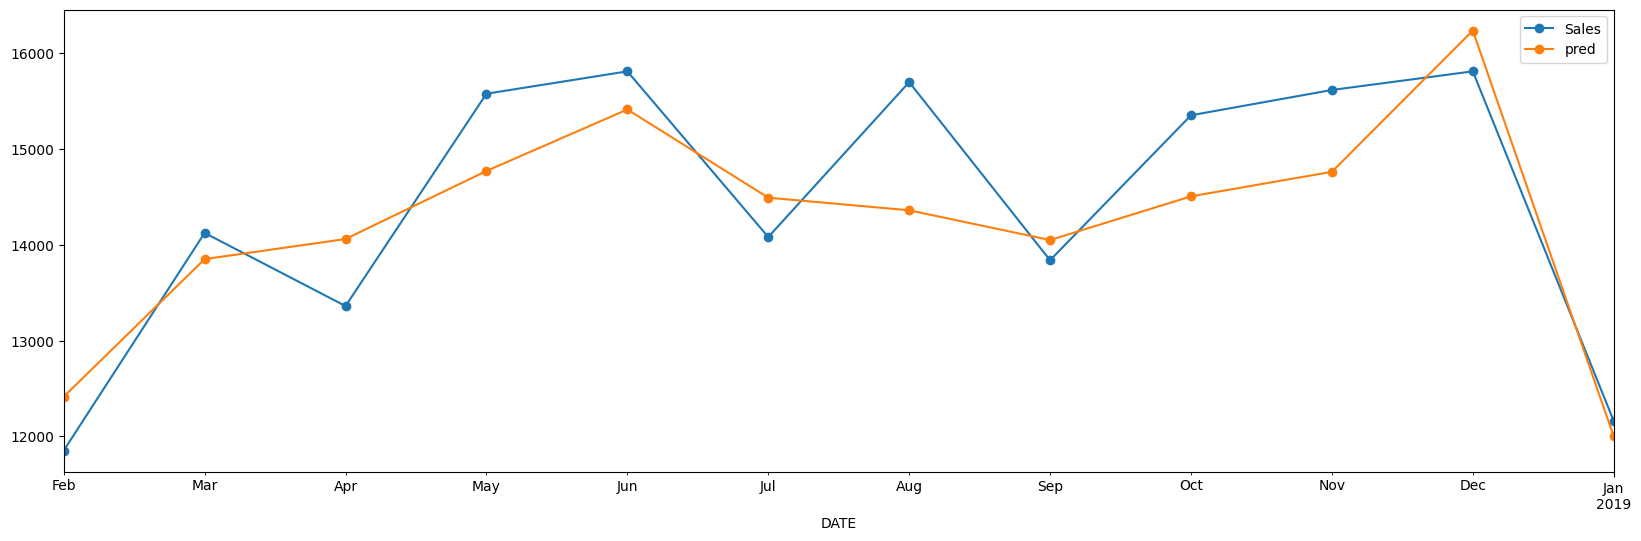

In [25]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In this plot we can clearly see that this model is having a better performance.

To back this, we can see that even MAPE error is only 6.8% now.

Also, the MAE and RMSE values have gone down a lot, from where we started.

#### Q. What if we take a mixture of additive and multiplicative models? Would that improve the performance?

MAE : 558.618
RMSE : 617.007
MAPE: 0.038


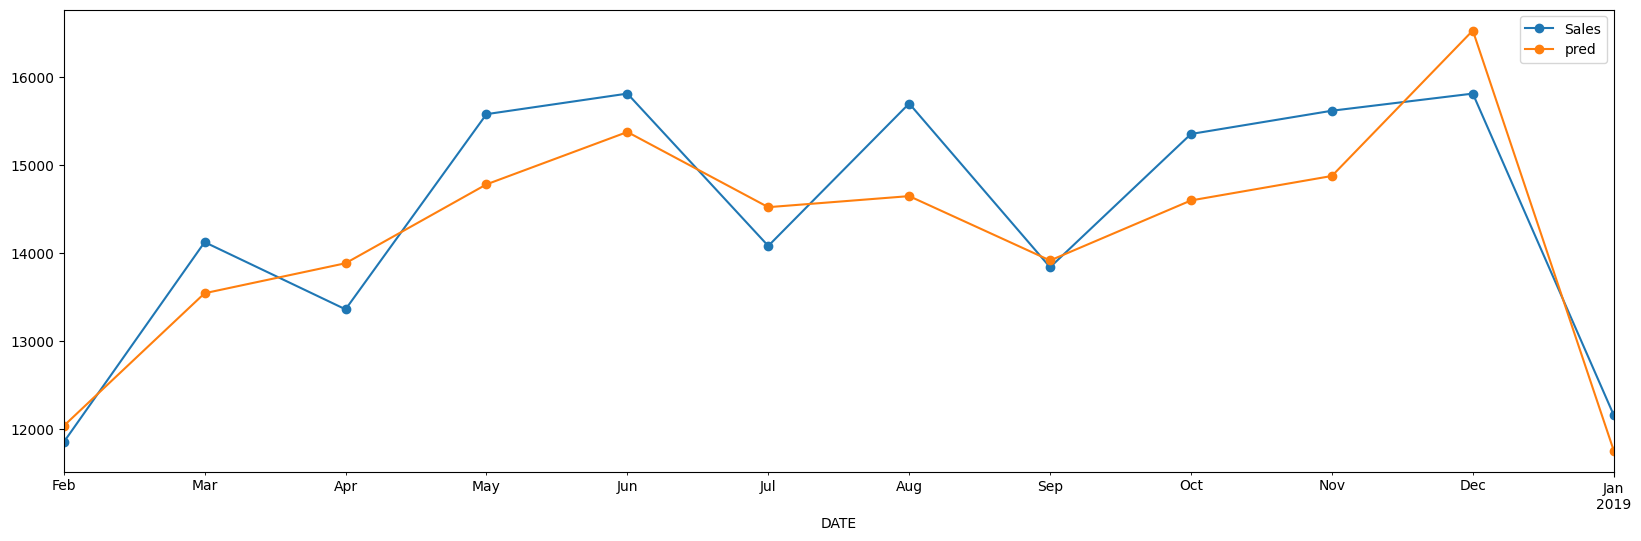

In [28]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

MAE : 488534784139.245
RMSE : 497187987765.962
MAPE: 34120366.05


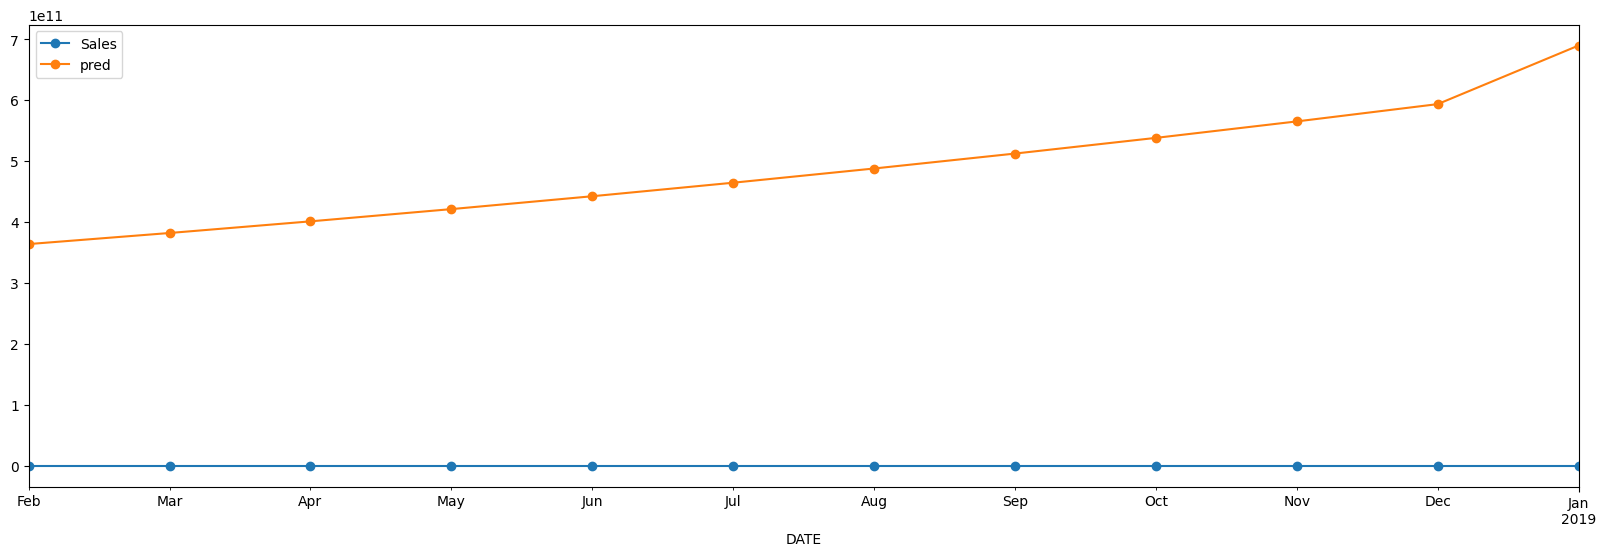

In [29]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='mul', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

MAE : 4.2995477323770066e+18
RMSE : 4.66771936804079e+18
MAPE: 296905614882793.9


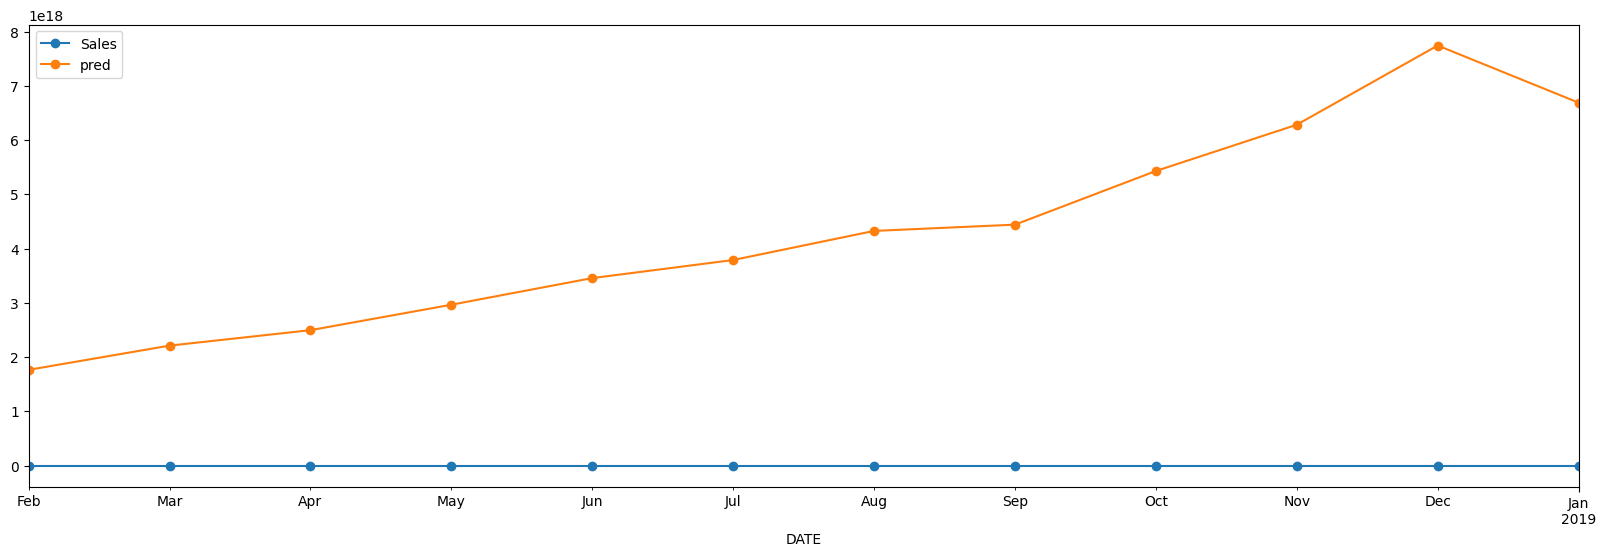

In [30]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='mul', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Here we can see that the performance of multiplicative model is better than linear model.

There is no rule for which model model (mul / add) to use when. We need to try and see which performs better.

###### **Quiz-1:**

```
What is the best model to predict monthly total population of a country? [Pre-covid]

a. SES
b. DES
c. TES
e. Moving Average

```
Answer: b -  roughly equal number of people are born each month, there is no seasonality in birth rate, so the population will linearly increase, hence DES.

---

## Stationarity

So far, we've been dealing with non-stationary time series. But in order to use certain forecasting methods (that we will see shortly), we need to the series to be stationary.

> **Q. What does it mean for a time series to be stationary?**

Being stationary means that, parameters (like mean, variance, amplitude, frequency) of the models should **not be dependent on time**.

Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.


**For example:** Heart beats (mean=0; standard deviation=1) is stationary — it does not matter when you observe it, it should look much the same at any point in time.

In general, a stationary time series will have no predictable patterns in the long-term.


<br>

> **Q. Why do we want to know if a time series is stationary?**

If a model's parameter varies over time, then there is a complex relation that needs to be modelled, which all models are not able to account for.

Many models assume the series to be stationary to be able to give useful results.

So, either we want to have a stationary time series, or convert to it.





<br>

> **Q. Which of the following time series is stationary?**

![picture](https://drive.google.com/uc?export=view&id=1pN4X8e7xNcQvnpgCmGgl7gQZURcD3kRy)

- `a, c, e, f, :` Not stationary
 - either have a trend, or
 - mean changing with time.
- `d, h:` Not stationary
 - Seasonality
- `i:` Not stationary
 - Has a trend
 - Variance is also not stable
 - Season
- `b:`
 Stationary
 - There is 1 outlier
 - Can't say anything about mean; seems to be just noise.
- `g:` Stationary
  - Predicting this is dicey, so we assume it to be stationary, and try building model, and seeing if it performs.
  - Looks like a cyclic time series. But these are not at regular intervals.
  - So, even though there  is some seasonality, it can't be predicted.

Categorizing a time series by just looking at it can be a little subjective.

For example, somebody may argue that `plot b` is non-stationary, as it looks like there may be some seasonality there.

### Dickey-Fuller Test

> **Q. Is there a test to help determine stationarity?**

There is a **statistical** method called **Dickey-Fuller test**, designed for testing for stationarity.

It fits an auto regressive model, checks if it worked or not. If it did, then that means it was a stationary time series.

There is a complicated mechanism to it. We don't need to know how it works. Just need to be aware of this test, as it can be handy.

<br>

> **Q. How can we implement Dickey-Fuller Test?**

We can find this as a built in function under **statmodels** library as `sm.tsa.stattools.adfuller()`.

<br>

> **Q. How do we interpret the result of Dickey-Fuller test?**

This test returns the **pvalue**.

In order for a time series to be stationary, the **pvalue** should be less than 0.05

Let's do the test for our timeseries

In [31]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

0.9789233920172065

The pvalue of the timeseries is very high, 0.98 approx.

So we can conclude that our time series is **not stationary**.

This makes sense because our time series has both, trend and seasonality.

Let's define a simple function to know if the plot is stationary or not.

In [32]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')


In [33]:
adf_test(mobile_sales.Sales)

Sequence is not stationary


So, we've established, our time series is not stationary. We need to tackle this.

<br>

> **Q. How do we convert a non stationary time series into a stationary time series?**

As per basic intuition, if we remove trend and seasonality, from our time series, it should become stationary.

If it's still not stationary, then maybe there's still some seasonality or trend component left in the series.

Ideally, trend gets removed in one step. However seasonality can take multiple steps to be removed.

These processes are called **Detrending** and **Deseasonalising** respectively.

---

### De-trending



Recall from the trend-seasonality decomposition that a time series can be written as <br>
$\hat{y_t} = m*x_t + c + s(t) + r(t)$ <br>
where $m*x_t + c$ represents the trend component

<br>

> **Q. How can we remove trend from the time series?**

In order to remove this, we can **differentiate** $\hat{y_t}$, with respect to time t. This way, we'll get a stationary time series. This gives us

$\frac{d\hat{y_t}}{dt} = m$, which is a constant.

One way to compute $\frac{d\hat{y_t}}{dt}$ is:

$\frac{d\hat{y_t}}{dt} \approx lim_{Δt → 0} \frac{y(t+Δt) - y(t)}{Δt}$

The minimum value of $Δt$ that we have is 1, since we're talking in terms on time, and our minimum step is 1 month. So the equation becomes: $\frac{d\hat{y_t}}{dt} \approx \frac{y(t+1) - y(t)}{1}$


This process is called **differencing**.

**Note:**
- Differencing gives a good approximation of differentiating
- Differentiating gives us a De-trended time series.


![picture](https://drive.google.com/uc?export=view&id=1Admg_50OXls05ZTytHbrNRpZtdHv4mpC)

<br>

> **Q. What if the trend line is not linear?**

If the time series has a non-linear trend, then we'll have to differentiate it multiple times, in order to finally achieve a stationary series.

**Note:**
- If the trend is an exponential function, then we'll not be able to convert it into stationary.
- This is a very rare cases.
- Some exponential functions can be approximated by polynomial. In that case, we differentiate this polynomial to obtain a stationary time series.

<br>

> **Q. How is this concept of differencing implemented?**

A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

$value(t) = observation(t) - observation(t-1)$


![picture](https://drive.google.com/uc?export=view&id=1XeLBXvc1jdUbrQQ6p94QvazTPlQmngTg)

This has the effect of removing a trend from a time series dataset.

<br>

Lets look at our series first.

<Axes: xlabel='DATE'>

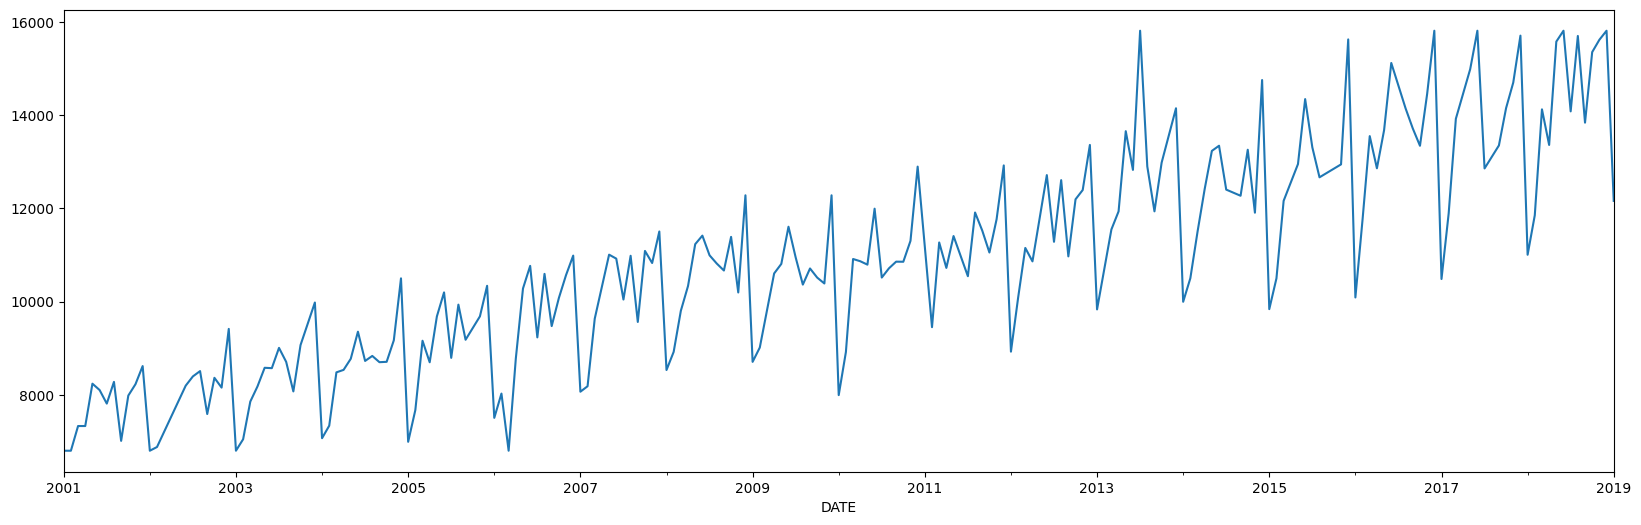

In [34]:
mobile_sales.Sales.plot()

> **Q. How can we implement this concept of differencing in code?**

We use the `diff()` method of **pandas**.

This method calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row, as the default value is 1).

<Axes: xlabel='DATE'>

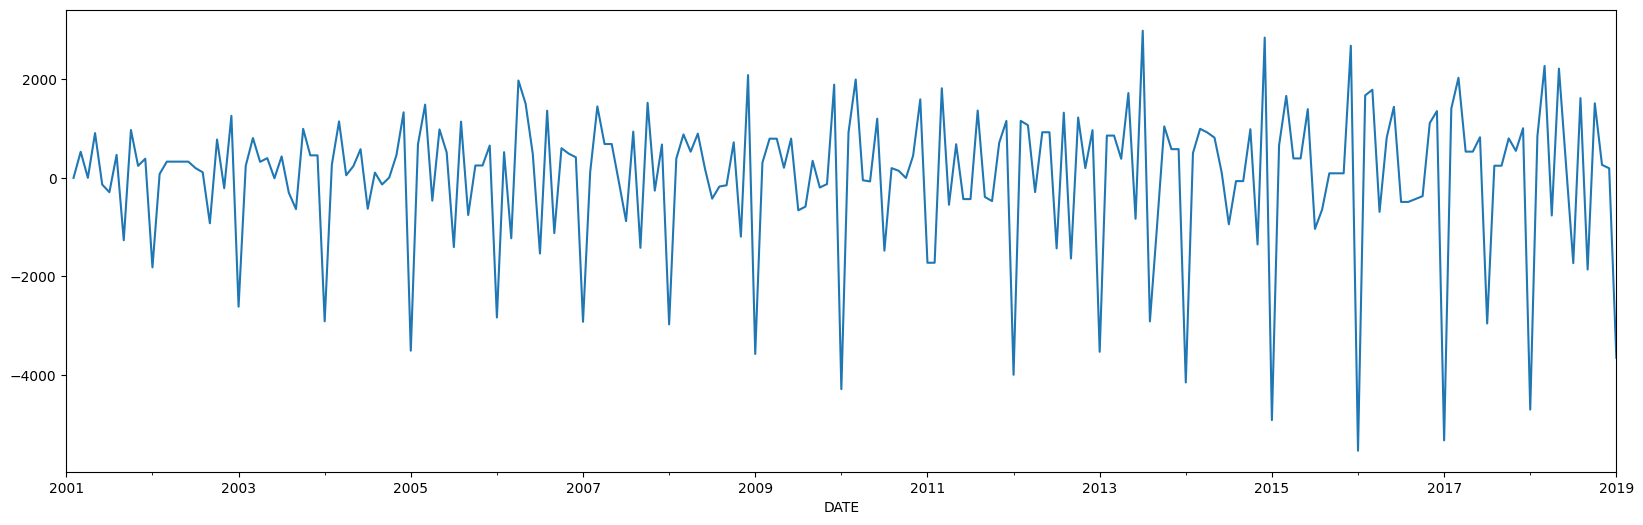

In [35]:
detrend = mobile_sales.Sales.diff()
detrend.plot()

As you can see, here the series has been detrended.

Let's perform the Dicker-Fuller test to cross check.

In [ ]:
adf_test(detrend.dropna())

Sequence is stationary


Though very less, there is still some seasonality, as can be seen.

### De-seasonalising

> **Q. How can we remove seasonality from the time series?**

Here also we can use differencing, but instead of subtracting from the last point, we need to take a difference from the last mth point, where m is the period of seasonality of series.

$Δy = y_t - y_{t-m}$

This is called **m-differencing**.

If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week.

In our case, since data is monthly, our m=12

![picture](https://drive.google.com/uc?export=view&id=1azP2NXIJjuvDb8gbwNJpIkuqSKdLiyT_)

<br>

> **Q. How can we implement this concept of differencing in code?**

Again, here also, We use the `diff()` method of **pandas**.

This time, since as per our data, m=12, we pass this as the parameter in `diff()`.

Now, lets do the **de-seasoning** and see the plot

<Axes: xlabel='DATE'>

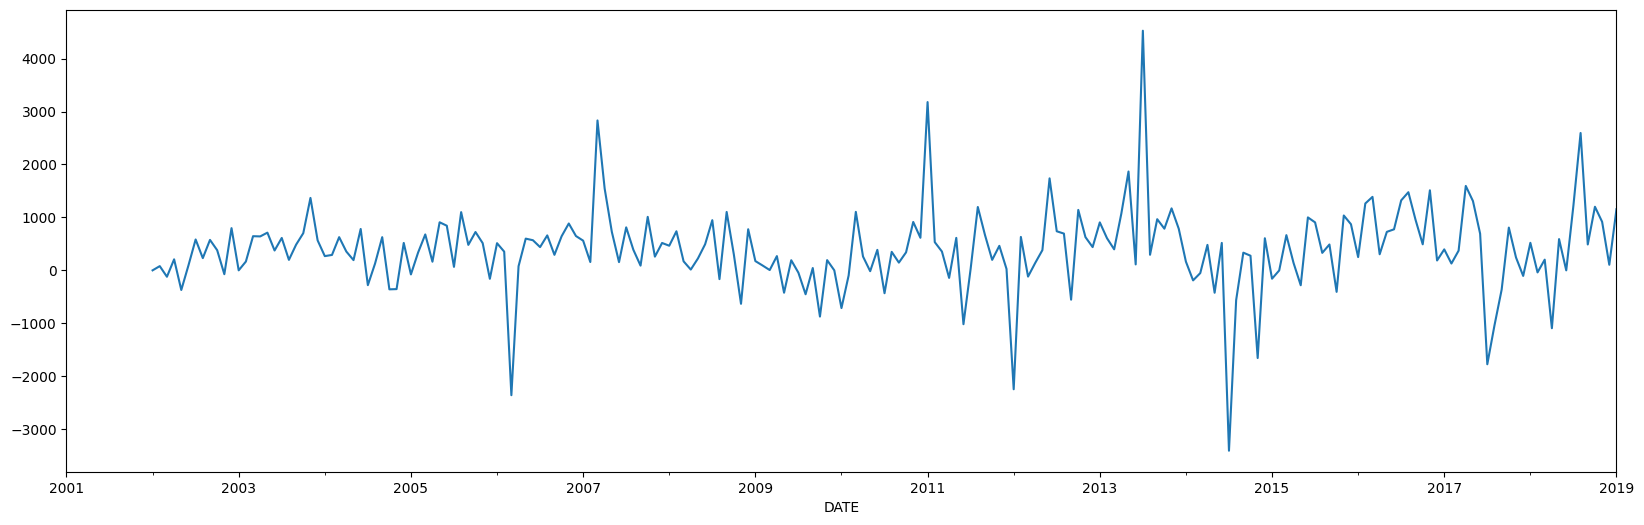

In [36]:
deseas = mobile_sales.Sales.diff(12)
deseas.plot()

In [39]:
adf_test(deseas.dropna())

Sequence is stationary


Here, as you can see we can still see very small trace of trend still.

Let's try detrending AND deseasonalising at once.

<Axes: xlabel='DATE'>

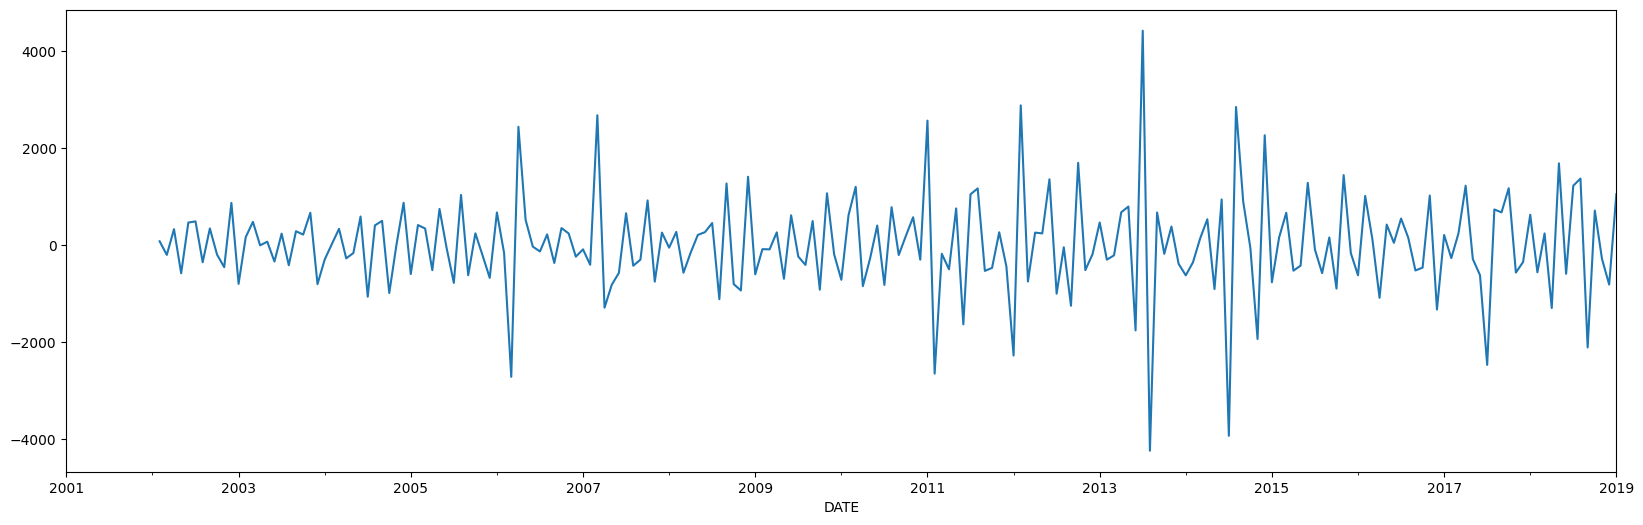

In [37]:
stationary = mobile_sales.Sales.diff(1).diff(12)
stationary.plot()

In [38]:
adf_test(stationary.dropna())

Sequence is stationary


As you can see, we've obtained a stationary time series.

**We have removed both trend and seasonality from the time series. So now all we have left is the error values:**

$y(t) - b(t) - s(t) = e(t)$

<br>

> **Here, we could visually see in the plot that value of m seems to be 12, but in other cases, it might not be obvious.**
- So we need to find the optimal value of m.


## AutoCorrelation and PartialAutoCorrelation